In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cp
import pygrib
import cfgrib
import glob
import stormeunice as eun

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

In [2]:
# dir(eun.data.Data

# Description

Identify extreme ensemble members in the operational forecast

Then, analyse these ensemble members in all three experiments (pi, curr, incr) wrt
- minimum pressure
- storm track 

Extreme members are identified by choosing high winds speeds and low pressures in areas indicated by ERA5 data from Feb, 18, 2022. We use the 95th percentile not the mean within the defined areas to make the method more robust to differences in the tracks.

# Import data

In [3]:
lon_min = -15
lon_max = 5
lat_min = 45
lat_max = 60
# region=[-70,25,50,70]  # Decider map

In [4]:
# ERA5

era5_2022 = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc')
era5_GUST = era5_2022.fg10.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='1d').max().load()

In [5]:
# EPS

directory = '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/'
eps = []  # making sure to start from a clean slate

for ind, cont in enumerate(['cf', 'pf']):
    for files in glob.glob(directory+cont+'/*.nc'):
        print(files)
        if len(eps) == ind+1:
            data = xr.open_dataset(files)
            data = eun.data.Data.preproc_ds(data.get(['fg10', 'msl']))  # preprocessing just one variable for speed
            eps[ind] = xr.concat([eps[ind], data], dim = 'inidate')
        else:
            eps.append(eun.data.Data.preproc_ds(xr.open_dataset(files).get(['fg10', 'msl'])))

eps = xr.concat(eps, dim = 'number')

/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-16.nc


# Identify extreme members

In [6]:
# Plot ERA5 sea level pressure at 12 noon for all dates within the range

era_feb18 = era5_2022.sel(time='2022-02-18 12').sel(latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max))

Based on the figure below, choose a box for the maximum winds and the minimum pressure

In [7]:
# wind gusts
full_map = [lon_min, lon_max, lat_min, lat_max]
fg10_box = full_map.copy()  #[-7, 2, 49, 54]  # lon_min, lon_max, lat_min, lat_max

# MSLP
msl_box = full_map.copy()  # [-6, 4, 52, 59]

/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


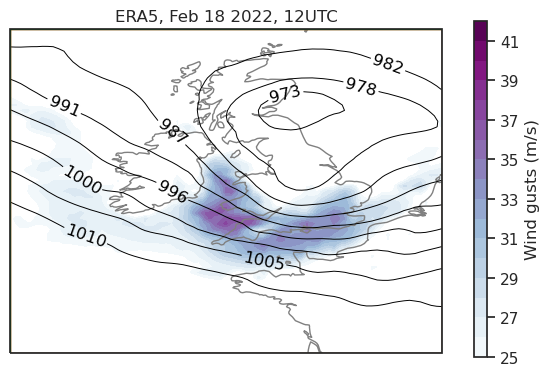

In [8]:
projection = ccrs.PlateCarree()
p_max = 1010
p_min = 960

fg10_min = 25
fg10_max = 42

fg10_vals = era_feb18.fg10.values[:,:]
p_vals = era_feb18.msl.values[:,:]/100
longitude = era_feb18.longitude.values
latitude = era_feb18.latitude.values

# figure and map setup
fig = plt.figure(1)
ax = plt.subplot(111, projection = projection)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# isobars as contours
clevs_p = np.linspace(p_min, p_max, 12)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection, linewidths = 0.7)
plt.clabel(cs, fmt='%d')

# fg10 as shading
clevs_fg10 = np.linspace(fg10_min, fg10_max, 18)
cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=plt.cm.BuPu,
                    transform=projection)


# outline for boxes
ax.plot([fg10_box[0], fg10_box[1], fg10_box[1], fg10_box[0], fg10_box[0]], [fg10_box[2], fg10_box[2], fg10_box[3], fg10_box[3], fg10_box[2]],
         color='red', linewidth=1)

ax.plot([msl_box[0], msl_box[1], msl_box[1], msl_box[0], msl_box[0]], [msl_box[2], msl_box[2], msl_box[3], msl_box[3], msl_box[2]],
         color='green', linewidth=1)


ax.set_title("ERA5, Feb 18 2022, 12UTC")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='Wind gusts (m/s)')

plt.savefig('figures/04_era5_decider-boxes.png')
plt.savefig('figures/04_era5_decider-boxes.pdf')

In [9]:
# Select data from shortest initialisation on Friday midday
eps_feb18 = eps.sel(inidate='2022-02-16',time='2022-02-18 12').sel(latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).squeeze()

# select wind gusts and pressure within the boxes for each ensemble member
eps_boxwinds = eps_feb18.sel(latitude=slice(fg10_box[3],fg10_box[2]),longitude=slice(fg10_box[0], fg10_box[1])).fg10.squeeze()
eps_boxpres = eps_feb18.sel(latitude=slice(msl_box[3],msl_box[2]),longitude=slice(msl_box[0], msl_box[1])).msl.squeeze()

# calculate 95th percentile for each member wtihin the box
fg10_95 = eps_boxwinds.quantile(0.95, dim = ['latitude', 'longitude'])
msl_05 = eps_boxpres.quantile(0.05, dim = ['latitude', 'longitude'])


In [10]:
print(fg10_95.sortby(fg10_95).number.values[:10])
print(fg10_95.sortby(fg10_95).number.values[-10:])

[40 39  3 19 31 41  5  6 22 50]
[ 7 28 25  4 12 49 11 18 43 33]


In [11]:
print(msl_05.sortby(msl_05).number.values[:10])
print(msl_05.sortby(msl_05).number.values[-10:])

[33 49 13 43 46 32  7 28 11 18]
[50  3 41 15 30 19 40  5 38 39]


# 2d scatterplot

In [12]:
rank = []
for number in range(0,51): 
    if (number in msl_05.sortby(msl_05).number.values[:10]) & (number not in fg10_95.sortby(fg10_95).number.values[-10:]):
        rank.append('extreme_pres')
    elif (number in fg10_95.sortby(fg10_95).number.values[-10:]) & (number not in msl_05.sortby(msl_05).number.values[:10]):
        rank.append('extreme_wind')
    elif (number in fg10_95.sortby(fg10_95).number.values[-10:]) & (number in msl_05.sortby(msl_05).number.values[:10]):
        rank.append('extreme_both')
    else:
        rank.append('none')

In [13]:
extreme_members = pd.DataFrame(data = {'number':list(range(0,51)), 
                                       'fg10_95':fg10_95.values,
                                       'msl_05':msl_05.values/100,
                                       'rank': rank})


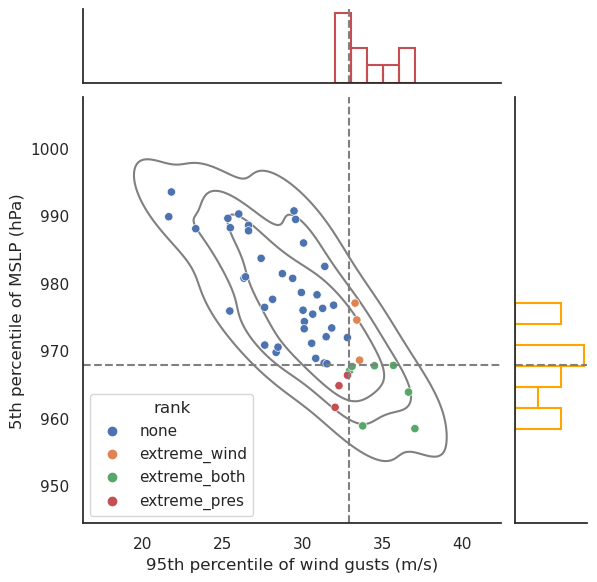

In [50]:
g = sns.JointGrid(data=extreme_members, x="fg10_95", y="msl_05")

sns.scatterplot(data = extreme_members,  x = 'fg10_95', y = 'msl_05', 
                color = 'black', marker = 'o', hue = 'rank', ax = g.ax_joint)

sns.histplot(data = extreme_members[(extreme_members['rank'].isin(['extreme_pres','extreme_both']))].fg10_95, 
            ax = g.ax_marg_x, color = 'r', fill = False)

sns.histplot(data = extreme_members[(extreme_members['rank'].isin(['extreme_wind','extreme_both']))],
             y = 'msl_05',
             ax = g.ax_marg_y, color = 'orange', fill = False)

g.plot_joint(sns.kdeplot, color="grey", zorder=0, levels=[0.05, 0.25, 0.5])

g.refline(x = fg10_95.sortby(fg10_95).values[-10:].min())
g.refline(y = msl_05.sortby(msl_05).values[:10].max()/100)

sns.despine()
g.set_axis_labels('95th percentile of wind gusts (m/s)','5th percentile of MSLP (hPa)')

plt.savefig('04_kdeplot_95th-5th-perc-wind-and-pressure.png')
plt.savefig('04_kdeplot_95th-5th-perc-wind-and-pressure.pdf')


In [39]:
fg10_95.values.min()

21.614492416381836

In [47]:
fg10_95.sortby(fg10_95).values[-10:].min()

32.938812255859375